# Swapping Convolution Layers Test

##### Summary:
Swap first 50 layers between FAT and FedAvg models of CIFAR-10 data set and measure test acc + robustness. The goal is to see if injecting a fraction of the model via ARU can reduce robustness of it significantly

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
setting, num_user = "FedAvg_adv", 20

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = "fakenewsnet") # Indicate dataset here

# Load models for FAT and FedAvg
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FAT_ep02/'
save_path_FedAvg = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FedAvg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


==> Clients initialization..
===> Building data iterators..


 95%|█████████▌| 19/20 [00:01<00:00, 15.87it/s]


===> Initializing clients..


100%|██████████| 20/20 [00:00<00:00, 20.27it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:288: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  learner.model.load_state_dict(tor

In [4]:
# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key]

In [5]:
# Gather statistics layer by layer
# 1. Number of paramters per layer
# 2. Standard Deviation per layer 
# 3. Difference between np.mean layer(FedAvg - FAT) * num param

num_params_list = []
std_params_list_FedAvg = []
std_params_list_FAT = []
diff_normalized = []

for key in desired_keys:
    mat_FedAvg = params_FedAvg[key]
    mat_FAT = params_FAT[key]
    num_params = params_FedAvg[key].numel()
    num_params_list += [num_params]


    if num_params > 1:
        std_params = torch.std(mat_FedAvg)
        std_params_list_FedAvg += [std_params]
        std_params_list_FAT += [torch.std(mat_FAT)]
        diff_normalized += [torch.mean(torch.abs(mat_FedAvg - mat_FAT)/std_params)]
    else:
        std_params_list_FedAvg += [0]
        std_params_list_FAT += [0]
        diff_normalized += [torch.abs(mat_FedAvg - mat_FAT)]




: 

In [6]:
desired_keys

['conv1.weight',
 'conv1.bias',
 'conv1_bn.weight',
 'conv1_bn.bias',
 'conv2.weight',
 'conv2.bias',
 'conv2_bn.weight',
 'conv2_bn.bias',
 'conv3.weight',
 'conv3.bias',
 'conv3_bn.weight',
 'conv3_bn.bias',
 'fc1.weight',
 'fc1.bias',
 'fc2.weight',
 'fc2.bias']

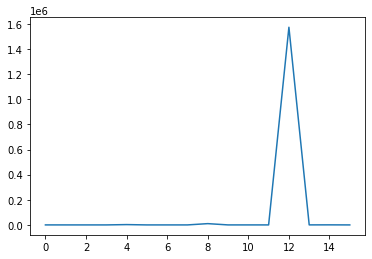

In [7]:
### Number of parameters per layer
# y axis - number of parameter
# x axis - layer id
plt.plot(num_params_list)

In [8]:
params_FAT.keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv1_bn.weight', 'conv1_bn.bias', 'conv1_bn.running_mean', 'conv1_bn.running_var', 'conv1_bn.num_batches_tracked', 'conv2.weight', 'conv2.bias', 'conv2_bn.weight', 'conv2_bn.bias', 'conv2_bn.running_mean', 'conv2_bn.running_var', 'conv2_bn.num_batches_tracked', 'conv3.weight', 'conv3.bias', 'conv3_bn.weight', 'conv3_bn.bias', 'conv3_bn.running_mean', 'conv3_bn.running_var', 'conv3_bn.num_batches_tracked', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])

In [9]:
# Linear extrapolation of model for each layer
stepsize_alpha = 0.05
alpha_set = np.arange(0,1+stepsize_alpha,stepsize_alpha)

params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Make the model with just 50 first layers
new_model = copy.deepcopy(model_FAT)
new_model.eval()
new_weight_dict = copy.deepcopy(params_FAT)

counter = 0
threshold = 22 # 22 is good for fakenewsnet
for key in params_FAT:
    if threshold == 22:
        new_weight_dict[key] = params_FedAvg[key]
    counter += 1
    if counter >= threshold:
        break

new_model.load_state_dict(new_weight_dict)

models_test = [model_Fedavg, model_FAT, new_model]


In [10]:
# Perform transfer attack from one client to another and record stats
# models_test = [model_Fedavg, model_FAT]

num_trials = 5
acc_store_agg = np.zeros([num_trials, len(models_test)])
adv_store_agg = np.zeros([num_trials, len(models_test)])

for itt in range(num_trials):

    # Run Measurements for both targetted and untargeted analysis
    victim_idxs = range(len(models_test))
    logs_adv = generate_logs_adv(len(models_test))
    custom_batch_size = 100
    eps = 0.1

    dataloader = load_client_data(clients = clients, c_id = 0, mode = 'all') # or test/train
    cross_attack(logs_adv, victim_idxs, dataloader, models_test, custom_batch_size, eps)

    metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
                'adv_similarities_untarget','adv_target','adv_miss']

    adv_miss = get_metric_list("adv_miss", logs_adv, victim_idxs)
    acc = get_metric_list("orig_acc_transfers", logs_adv, victim_idxs)

    # Print along diagonal and plot "robustness against white-box attacks (self)"
    adv_list = []
    acc_list = []
    for i in range(adv_miss.shape[0]):
        adv_list += [adv_miss[i,i]]
        acc_list += [acc[i,i]]

    acc_store_agg[itt,:] = np.array(acc_list)
    adv_store_agg[itt,:] = np.array(adv_list)



	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2


In [11]:
### printing results after running adv acc measurement experiment before and after swapping layers

acc_list_true = np.mean(acc_store_agg, axis = 0)
adv_list_true = np.mean(adv_store_agg, axis = 0)

acc_list_std = np.std(acc_store_agg, axis = 0)
adv_list_std = np.std(adv_store_agg, axis = 0)

print("model   :  FAvg FAT  Repl ")
print("Test Acc:",acc_list_true)
print("Adv  Acc:",adv_list_true)
print("Test Acc std:",acc_list_std)
print("Adv  Acc std:",adv_list_std)

model   :  FAvg FAT  Repl 
Test Acc: [0.79 0.75 0.79]
Adv  Acc: [0.05 0.37 0.05]
Test Acc std: [0.04 0.04 0.02]
Adv  Acc std: [0.02 0.05 0.02]


In [16]:
acc_list_true[2]

0.7899999856948853

: 